In [93]:
import gymnasium as gym
import numpy as np
import optuna
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

In [94]:
class IbuprofenEnv(gym.Env):
    def __init__(self, normalize=False):
        super(IbuprofenEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)
        self.therapeutic_range = (10, 50)
        self.half_life = 2.0
        self.clearance_rate = 0.693 / self.half_life
        self.time_step_hours = 1
        self.bioavailability = 0.9
        self.volume_of_distribution = 0.15
        self.max_steps = 24
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.normalize = normalize
        self.state_buffer = []

    def reset(self, seed=None, **kwargs):
        super().reset(seed=seed)
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.state_buffer = []
        state = np.array([self.plasma_concentration], dtype=np.float32)
        return self._normalize(state), {}

    def step(self, action):
        dose_mg = action * 200
        absorbed_mg = dose_mg * self.bioavailability
        absorbed_concentration = absorbed_mg / (self.volume_of_distribution * 70)
        self.plasma_concentration += absorbed_concentration
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        state = np.array([self.plasma_concentration], dtype=np.float32)
        normalized_state = self._normalize(state)

        self.state_buffer.append(self.plasma_concentration)

        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10
        else:
            if self.plasma_concentration < self.therapeutic_range[0]:
                reward = -5 - (self.therapeutic_range[0] - self.plasma_concentration) * 0.5
            elif self.plasma_concentration > self.therapeutic_range[1]:
                reward = -5 - (self.plasma_concentration - self.therapeutic_range[1]) * 0.5

        if self.plasma_concentration > 100:
            reward -= 15

        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False
        info = {}

        return normalized_state, reward, done, truncated, info

    def _normalize(self, state):
        if self.normalize and len(self.state_buffer) > 1:
            mean = np.mean(self.state_buffer)
            std = np.std(self.state_buffer) + 1e-8
            return (state - mean) / std
        return state


In [95]:
class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super(RewardLoggingCallback, self).__init__()
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        # Accumulate reward for the current step
        self.current_episode_reward += self.locals["rewards"][0]

        # If the episode ends, log the reward
        if self.locals["dones"][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        return True

In [96]:
def optimize_ppo(trial):
    env = DummyVecEnv([lambda: IbuprofenEnv(normalize=True)])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    n_epochs = trial.suggest_int("n_epochs", 3, 10)
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    n_steps = trial.suggest_int("n_steps", 64, 2048, step=64)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.99)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        batch_size=batch_size,
        n_steps=n_steps,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        verbose=0,
    )
    model.learn(total_timesteps=100000)

    rewards = []
    for _ in range(100):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)

    return np.mean(rewards)

In [97]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=100)

best_params = study.best_params
print("Best Parameters:", best_params)

[I 2024-12-08 19:35:47,026] A new study created in memory with name: no-name-1799026b-0232-4df7-a457-10c76dbda814
[I 2024-12-08 19:37:25,410] Trial 0 finished with value: -240.0 and parameters: {'learning_rate': 1.8512552019580036e-05, 'gamma': 0.9093893860595554, 'n_epochs': 10, 'ent_coef': 0.002807016303848965, 'batch_size': 160, 'n_steps': 1280, 'gae_lambda': 0.8186137249161137, 'clip_range': 0.18855569643461273}. Best is trial 0 with value: -240.0.
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning:

You have specified a mini-batch size of 192, but because the `RolloutBuffer` is of size `n_steps * n_envs = 512`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=512 and n_envs=1)

[I 2024-12-08 19:38:58,041] Trial 1 finished with value: 240.0 and parameters: {'learning_rate': 0.0001214831198579504, 'gamma': 

Best Parameters: {'learning_rate': 0.0001214831198579504, 'gamma': 0.9215878224778579, 'n_epochs': 3, 'ent_coef': 0.0008820629385330285, 'batch_size': 192, 'n_steps': 512, 'gae_lambda': 0.8820349836460262, 'clip_range': 0.23990510102852083}


In [98]:
env = DummyVecEnv([lambda: IbuprofenEnv(normalize=True)])

final_model = PPO(
    "MlpPolicy",
    env,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    n_epochs=best_params["n_epochs"],
    ent_coef=best_params["ent_coef"],
    batch_size=best_params["batch_size"],
    n_steps=best_params["n_steps"],
    gae_lambda=best_params["gae_lambda"],
    clip_range=best_params["clip_range"],
    verbose=1,
)
callback = RewardLoggingCallback()
final_model.learn(total_timesteps=240000, callback=callback)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1734 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1547          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.6694287e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.24          |
|    entropy_loss         | -1.61         |
|    explained_variance   | 0.00168       |
|    learning_rate        | 0.000121      |
|    loss                 | 5.08e+03      |
|    n_updates            | 3             |
|    policy_gradient_loss | -0.00172      |
|    value_loss           | 1.07e+04      |
-------------------------

In [99]:
# Training Loop with Dynamic Time Horizon
# Initialize variables for dynamic time horizon
initial_horizon = 6  # Start with a small time horizon (e.g., 6 hours)
max_horizon = 24     # Full time period (24 hours, in your case)
horizon_increment = 2  # Increase the horizon incrementally
time_horizon = initial_horizon

reward_history = []

# Use a loop for multiple training episodes
for episode in range(1000):  # Number of training episodes
    # Dynamically update the time horizon
    time_horizon = min(max_horizon, initial_horizon + episode * horizon_increment)

    # Reset environment at the beginning of each episode
    state = env.reset()

    total_reward = 0
    plasma_concentration_history = []

    for t in range(time_horizon):  # Use the dynamic time horizon
        # Use the SB3 predict method for actions
        action, _ = final_model.predict(state, deterministic=False)

        # Take a step in the environment
        new_state, reward, done, infos = env.step(action)
        plasma_concentration_history.append(new_state[0])

        # Accumulate the reward
        total_reward += reward

        # Update the current state
        state = new_state

        if done:
            break

    # Append total reward for the episode
    reward_history.append(total_reward)

    # Log progress every 10 episodes
    if episode % 10 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}, Time Horizon = {time_horizon}")


Episode 0: Total Reward = [60.], Time Horizon = 6
Episode 10: Total Reward = [240.], Time Horizon = 24
Episode 20: Total Reward = [240.], Time Horizon = 24
Episode 30: Total Reward = [240.], Time Horizon = 24
Episode 40: Total Reward = [240.], Time Horizon = 24
Episode 50: Total Reward = [240.], Time Horizon = 24
Episode 60: Total Reward = [240.], Time Horizon = 24
Episode 70: Total Reward = [240.], Time Horizon = 24
Episode 80: Total Reward = [240.], Time Horizon = 24
Episode 90: Total Reward = [240.], Time Horizon = 24
Episode 100: Total Reward = [240.], Time Horizon = 24
Episode 110: Total Reward = [240.], Time Horizon = 24
Episode 120: Total Reward = [240.], Time Horizon = 24
Episode 130: Total Reward = [240.], Time Horizon = 24
Episode 140: Total Reward = [240.], Time Horizon = 24
Episode 150: Total Reward = [240.], Time Horizon = 24
Episode 160: Total Reward = [240.], Time Horizon = 24
Episode 170: Total Reward = [240.], Time Horizon = 24
Episode 180: Total Reward = [240.], Time 

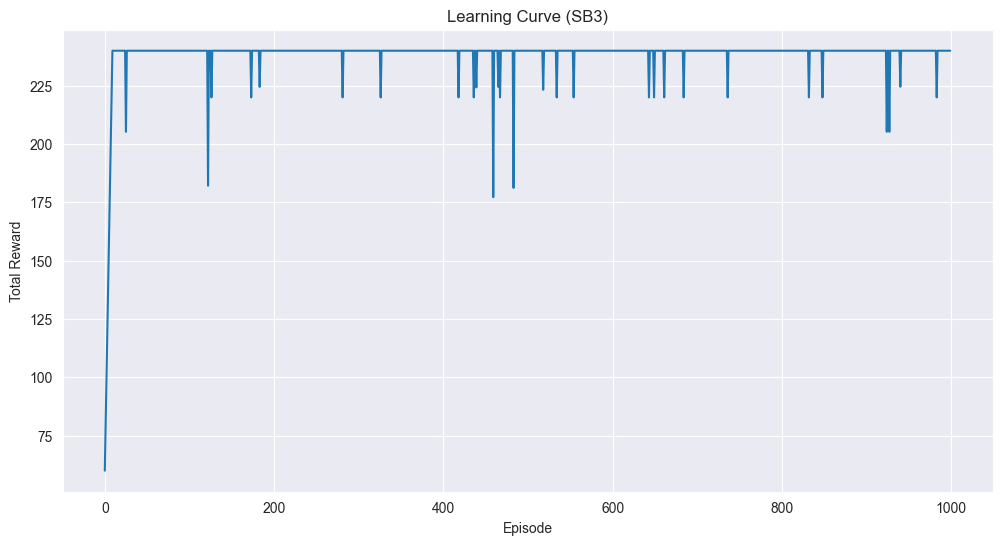

In [100]:
# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve (SB3)")
plt.grid(True)
plt.show()

In [101]:

# Evaluation Loop
evaluation_episodes = 100  # Number of episodes for evaluation

evaluation_rewards = []
plasma_concentration_trajectories = []

# Access the underlying environment from DummyVecEnv
underlying_env = env.envs[0]  # envs[0] gives access to the unwrapped IbuprofenEnv

for episode in range(evaluation_episodes):
    state, _ = underlying_env.reset()

    total_reward = 0
    plasma_concentration_history = [state[0]]  # Track plasma concentration

    for _ in range(underlying_env.max_steps):  # Use max_steps from the underlying environment
        # Use the SB3 predict method for actions
        action, _ = final_model.predict(state, deterministic=True)

        # Take the chosen action in the environment
        new_state, reward, done, truncated, _ = underlying_env.step(action)
        plasma_concentration_history.append(new_state[0])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    evaluation_rewards.append(total_reward)
    plasma_concentration_trajectories.append(plasma_concentration_history)


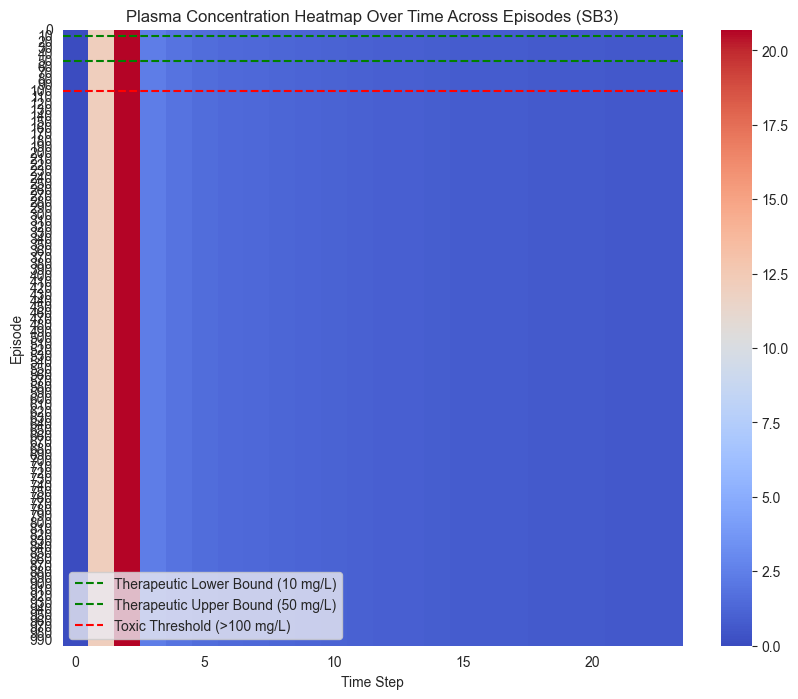

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables to store plasma concentration trajectories over episodes
plasma_concentrations_over_episodes = []

# Run the agent for several episodes to collect plasma concentration data
for episode in range(1000):  # Number of training episodes
    state_trajectory = []  # Store the plasma concentration for this episode
    state = env.reset()  # Corrected to unpack only one value (state)
    done = False

    while not done:
        state_trajectory.append(state[0])  # Record plasma concentration
        action, _ = final_model.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)  # Correct unpacking for DummyVecEnv

    # Append the trajectory of plasma concentrations for this episode
    plasma_concentrations_over_episodes.append(state_trajectory)

# Convert the list of plasma concentrations into a 2D array (episodes x time steps)
# Flatten the 3D array (100, 24, 1) into a 2D array (100, 24)
plasma_concentrations_matrix = np.squeeze(np.array(plasma_concentrations_over_episodes))

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(plasma_concentrations_matrix, cmap='coolwarm', annot=False, cbar=True, xticklabels=5, yticklabels=10)
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Episode')
plt.title('Plasma Concentration Heatmap Over Time Across Episodes (SB3)')
plt.legend()
plt.grid()
plt.show()


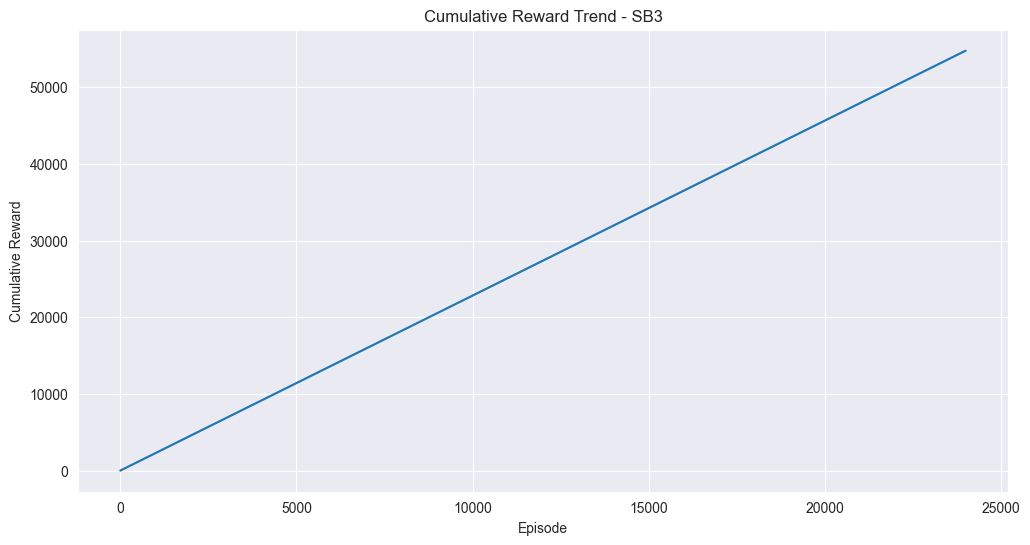

In [103]:

cumulative_rewards = np.cumsum(plasma_concentrations_over_episodes)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Trend - SB3")
plt.grid(True)
plt.show()

In [104]:
optuna.visualization.plot_optimization_history(study).show()


In [105]:
optuna.visualization.plot_param_importances(study).show()


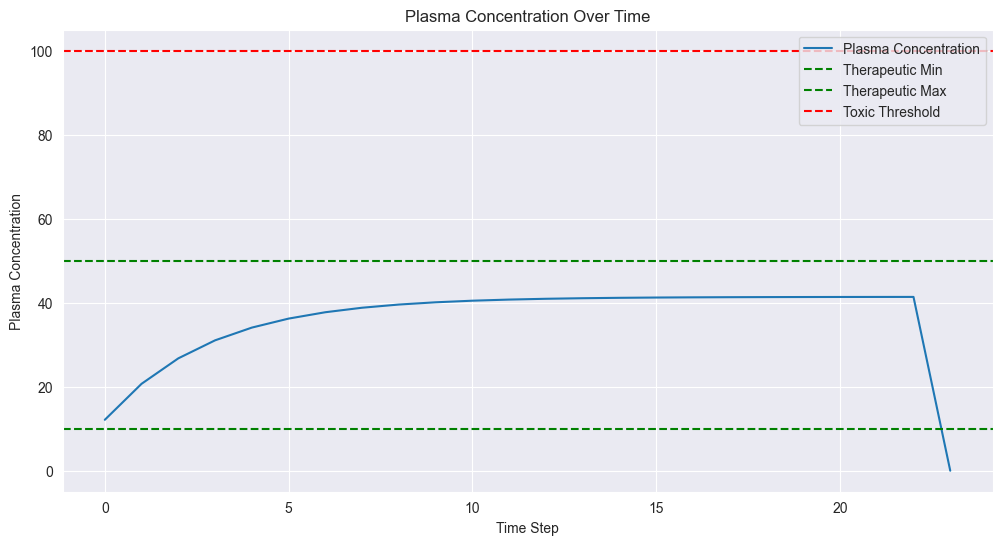

In [106]:
def plot_last_episode_concentration(env, model, therapeutic_range=(10, 50), toxic_threshold=100):
    obs = env.reset()
    plasma_concentrations = []
    done = False
    while not done:
        # Get action from the model
        action, _ = model.predict(obs, deterministic=True)
        # Unpack the four values returned by step
        obs, _, done, info = env.step(action)
        # Access the plasma concentration from the environment
        plasma_concentrations.append(env.envs[0].plasma_concentration)  # Collect plasma concentration

    # Plot the plasma concentration
    plt.figure(figsize=(12, 6))
    plt.plot(plasma_concentrations, label="Plasma Concentration")
    plt.axhline(y=therapeutic_range[0], color='green', linestyle='--', label="Therapeutic Min")
    plt.axhline(y=therapeutic_range[1], color='green', linestyle='--', label="Therapeutic Max")
    plt.axhline(y=toxic_threshold, color='red', linestyle='--', label="Toxic Threshold")
    plt.xlabel("Time Step")
    plt.ylabel("Plasma Concentration")
    plt.title("Plasma Concentration Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate and plot the last episode
env = DummyVecEnv([lambda: IbuprofenEnv(normalize=False)])  # Use the original, non-normalized environment
plot_last_episode_concentration(env, final_model)
